In [ ]:
party_id = 0

num_partes = 1  ## number of participating parties
nomeParte = 'pneumoniamnist_0.npz'
dataset = 'pneumoniamnist'
handlerName = 'PneumoniaMedmnistDataHandler'
handler ='pneumoniaHandler.py'

# Gerando a base de dados para os modelos existentes na ferramenta

Para executar o aprendizado federado da IBM, você deve ter arquivos de configuração para o agregador e para cada parte.

A ferramenta da **IBM** possui alguns datasets já configurados a título de exemplificação. Para todos esses exemplos, existe um arquivo **generate_data.py** para que possamos particionar a base de dados a partir dos seguintes sinalizadores: 

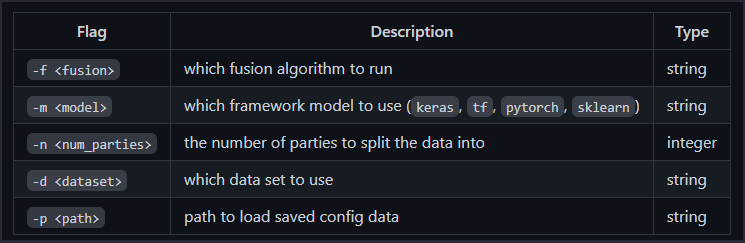

In [ ]:
%run examples/generate_data.py -n $num_parties -d $dataset -pp 200

In [ ]:
import numpy as np

class DivisorArquivoNpz:
    def __init__(self, nome_arquivo, num_partes):
        self.nome_arquivo = nome_arquivo
        self.num_partes = num_partes

    def dividir(self):
        # Carregue o arquivo npz
        data = np.load(f'{self.nome_arquivo}.npz')

        # Divida os dados do arquivo em partes iguais
        partes = {}
        for chave, valor in data.items():
            partes[chave] = np.array_split(valor, self.num_partes)

        # Salve cada parte em um novo arquivo npz
        for i in range(self.num_partes):
            nome_arquivo = f'{self.nome_arquivo}_{i}.npz'
            np.savez(nome_arquivo, **{chave: valor[i] for chave, valor in partes.items()})

In [ ]:
divisor = DivisorArquivoNpz(dataset, 2)
divisor.dividir()

In [ ]:
import numpy as np

# carregar o arquivo npz
data = np.load('./pneumoniamnist.npz')

# obter os arrays de dados e etiquetas
x_train = data['train_images'] # array com os dados
y_train = data['train_labels'] # array com as etiquetas

x_test = data['test_images'] # array com os dados
y_test = data['test_labels'] # array com as etiquetas

x_val = data['val_images'] # array com os dados
y_val = data['val_labels'] # array com as etiquetas

# obter as classes únicas
classes_train = np.unique(y_train)
classes_test = np.unique(y_test)
classes_val = np.unique(y_val)

# percorrer as classes
for classe in classes_train:

    idx_classe_train = np.where(y_train == classe)[0]
    dados_classe_train = x_train[idx_classe_train]
    etiquetas_classe_train = y_train[idx_classe_train]

    idx_classe_test = np.where(y_test == classe)[0]
    dados_classe_test = x_test[idx_classe_test]
    etiquetas_classe_test = y_test[idx_classe_test]

    idx_classe_val = np.where(y_val == classe)[0]
    dados_classe_val = x_val[idx_classe_val]
    etiquetas_classe_val = y_val[idx_classe_val]
    
    np.savez(f'dados_{classe}.npz', 
         train_images=dados_classe_train, train_labels=etiquetas_classe_train,
         test_images=dados_classe_test, test_labels=etiquetas_classe_test,
         val_images=dados_classe_val, val_labels=etiquetas_classe_val)

In [ ]:
divisor = DivisorArquivoNpz('dados_0', 2)
divisor.dividir()

divisor = DivisorArquivoNpz('dados_1', 2)
divisor.dividir()

In [ ]:
arquivo = open(handler, "w")
arquivo.write("""
import logging

import numpy as np
import tensorflow as tf

from ibmfl.data.data_handler import DataHandler
logger = logging.getLogger(__name__)

class PneumoniaMedmnistDataHandler(DataHandler):

    def __init__(self, data_config=None, channels_first=False):
        super().__init__()

        self.file_name = None
        if data_config is not None:
            if 'npz_file' in data_config:
                self.file_name = data_config['npz_file']
        self.channels_first = channels_first

        # load the datasets
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_dataset()
        # pre-process the datasets
        self.preprocess()
    
    def load_dataset(self, nb_points=500):
 
        # if self.file_name is None:
        #     (x_train, y_train), (x_test, y_test) = load_mnist()
        #     # Reduce datapoints to make test faster
        #     x_train = x_train[:nb_points]
        #     y_train = y_train[:nb_points]
        #     x_test = x_test[:nb_points]
        #     y_test = y_test[:nb_points]
        # else:
        try:
            logger.info('Loaded training data from ' + str(self.file_name))
            data_train = np.load(self.file_name)
            x_train = data_train['train_images']
            y_train = data_train['train_labels']
            x_test = data_train['test_images']
            y_test = data_train['test_labels']
        except Exception:
            raise IOError('Unable to load training data from path '
                            'provided in config file: ' +
                            self.file_name)
        return (x_train, y_train), (x_test, y_test)

    def get_data(self):
    
        return ((self.x_train, self.y_train), (self.x_test, self.y_test))

    def preprocess(self):

        num_classes = 10
        img_rows, img_cols = 28, 28

        if self.channels_first:
            self.x_train = self.x_train.reshape(self.x_train.shape[0], 1, img_rows, img_cols)
            self.x_test = self.x_test.reshape(self.x_test.shape[0], 1, img_rows, img_cols)
        else:
            self.x_train = self.x_train.reshape(self.x_train.shape[0], img_rows, img_cols, 1)
            self.x_test = self.x_test.reshape(self.x_test.shape[0], img_rows, img_cols, 1)
            
        self.y_train = np.eye(num_classes)[self.y_train]
        self.y_test = np.eye(num_classes)[self.y_test]
        self.y_train = self.y_train.reshape((-1,num_classes))
        self.y_test = self.y_test.reshape((-1,num_classes))
""")

arquivo.close()

# Definição do aggregator

O agregador carrega consigo as informações de conexão referentes a máquina de execução. Além disso, seu arquivo de configuração possui informações sobre o algoritmo de **fusão**, **hiper parâmetros do treinamento** e o **protocolo**.

* **Connection:** Possui informações como **IP** e **porta** da máquina agregadora além do tipo da conexão, que no exemplo a seguir foi utilizado **Flask**.

* **Data:** Possui informações sobre os dados a serem trabalhados, como por exemplo, o caminho do arquivo **.npz** da base de dados e o **Handler** específico para a leitura dessas informações.

* **Fusion:** Este campo especifica quais dos métodos de fusão será utilizado. Pox exemplo, **Iterative Average**, **FedAvg**, **Gradient Average**, entre outros.

* **Hiper parâmetros:** Existem dois tipos de Hiper parâmetros. Globais e locais, no global é definido o tempo máximo de conexão, a quantidade de participantes do treinamento, quorum mínimo de participantes para que um treinamento se inicie, quantidade de épocas globais e acurácia nínima para  que o treinamento seja interrompido. Já os hiper parâmetros locais definem a quantidade de épocas locais e o valor do otimizador.

In [ ]:
def get_party_config(party_id):
    party_config = {
        'aggregator':
            {
                'ip': '168.138.156.126',
                'port': 5000
            },
        'connection': {
            'info': {
                'ip': '0.0.0.0',
                'port': 5000,
                'id': 'party' + str(party_id),
                'tls_config': {
                    'enable': False
                }
            },
            'name': 'FlaskConnection',
            'path': 'ibmfl.connection.flask_connection',
            'sync': False
        },
        'data': {
            'info': {
                'npz_file': str(nomeParte)
            },
            'name': handlerName,
            'path': handler
        },
        'local_training': {
            'name': 'LocalTrainingHandler',
            'path': 'ibmfl.party.training.local_training_handler'
        },
        'model': {
            'name': 'KerasFLModel',
            'path': 'ibmfl.model.keras_fl_model',
            'spec': {
                'model_definition': 'examples/configs/keras_classifier/compiled_keras.h5',
                'model_name': 'keras-cnn'
            }
        },
        'protocol_handler': {
            'name': 'PartyProtocolHandler',
            'path': 'ibmfl.party.party_protocol_handler'
        }
    }
    return party_config

# Iniciando o Participante

Para iniciar um novo agregador é preciso instânciar uma **Party** passando as configurações geradas acima. Logo após, o participante será iniciado e inscrito no agregador fornecido. Existem alguns comandos pré-configurados na própria biblioteca para realização do treinamento:

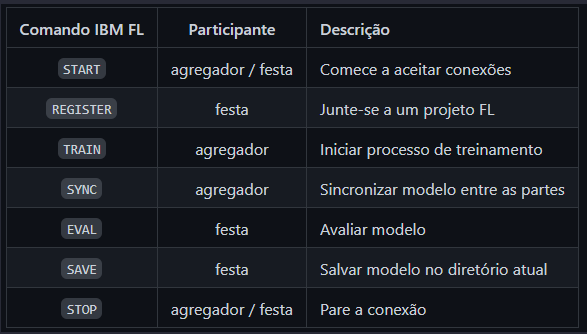

In [ ]:
from ibmfl.party.party import Party
import tensorflow as tf

party_config = get_party_config(party_id)
party = Party(config_dict=party_config)
party.start()
party.register_party()
party.proto_handler.is_private = False  ## allows sharing of metrics with aggregator
party.proto_handler.connection.source_info['ip'] = '3.145.98.236'

# Finalizando o treinamento

Por fim, devemos parar nosso participante utilizando o comando **STOP**.

In [ ]:
party.stop()